In [1]:
import numpy as np
import pandas as pd 
import pandas_ta as ta
import yfinance as yf
import sqlite3 

* DX-Y.NYB: US Dollar Index
* ^VIX: CBOE Volatility Index

In [118]:
conn = sqlite3.connect("../database.db")
stock_df = pd.read_sql("SELECT * FROM Ticker_1D WHERE Ticker = 'AAPL'", con=conn)

stock_df

,ID,Datetime,Open,High,Low,Close,Volume,Ticker,InsertTime
0,15088,2016-02-16 00:00:00.000000,21.520171,21.934630,21.427315,21.887070,196231600.0,AAPL,2026-02-14 14:19:32.733687
1,15089,2016-02-17 00:00:00.000000,21.893869,22.242650,21.776100,22.222267,179452800.0,AAPL,2026-02-14 14:19:32.733687
2,15090,2016-02-18 00:00:00.000000,22.385332,22.396657,21.762511,21.801014,156084000.0,AAPL,2026-02-14 14:19:32.733687
3,15091,2016-02-19 00:00:00.000000,21.742121,21.914247,21.696826,21.751181,141496800.0,AAPL,2026-02-14 14:19:32.733687
4,15092,2016-02-22 00:00:00.000000,21.812332,21.945956,21.724004,21.941425,137123200.0,AAPL,2026-02-14 14:19:32.733687
...,...,...,...,...,...,...,...,...,...
2510,17598,2026-02-09 00:00:00.000000,277.910004,278.200012,271.700012,274.619995,44623400.0,AAPL,2026-02-14 14:19:32.733687
2511,17599,2026-02-10 00:00:00.000000,274.890015,275.369995,272.940002,273.679993,34376900.0,AAPL,2026-02-14 14:19:32.733687
2512,17600,2026-02-11 00:00:00.000000,274.700012,280.179993,274.450012,275.500000,51931300.0,AAPL,2026-02-14 14:19:32.733687
2513,17601,2026-02-12 00:00:00.000000,275.589996,275.720001,260.179993,261.730011,81077200.0,AAPL,2026-02-14 14:19:32.733687


In [119]:
stock_df["Datetime"] = pd.to_datetime(stock_df["Datetime"])

stock_df["MACD"] = ta.macd(stock_df.Close).iloc[:, 0]
stock_df["ATR"] = ta.atr(stock_df.High, stock_df.Low, stock_df.Close)
stock_df["RSI"] = ta.rsi(stock_df.Close)


stock_df = stock_df.drop(columns=["ID", "High", "Low", "Volume", "Ticker", "InsertTime"])
stock_df = stock_df.dropna()
stock_df

,Datetime,Open,Close,MACD,ATR,RSI
25,2016-03-22,23.837066,24.169992,0.769228,0.423358,84.330971
26,2016-03-23,24.115637,24.036367,0.750690,0.412046,80.325022
27,2016-03-24,23.886896,23.932192,0.719301,0.404615,77.244334
28,2016-03-28,24.006931,23.823483,0.677839,0.393994,74.052627
29,2016-03-29,23.755540,24.387421,0.682616,0.412927,78.918923
...,...,...,...,...,...,...
2510,2026-02-09,277.910004,274.619995,2.680348,6.026760,63.218734
2511,2026-02-10,274.890015,273.679993,2.945728,5.769848,61.599554
2512,2026-02-11,274.700012,275.500000,3.265263,5.822001,63.546345
2513,2026-02-12,275.589996,261.730011,2.379939,6.516145,44.970278


In [120]:
unemployment = pd.read_sql("SELECT * FROM Macroeconomic_Data WHERE Metric = 'URATE'", con=conn)
inflation = pd.read_sql("SELECT * FROM Macroeconomic_Data WHERE Metric = 'IRATE'", con=conn)
consumer_sentiment = pd.read_sql("SELECT * FROM Macroeconomic_Data WHERE Metric = 'CSI'", con=conn)
usd_index = pd.read_sql("SELECT * FROM Ticker_1D WHERE Ticker = 'DX-Y.NYB'", con=conn)
cboe_vol = pd.read_sql("SELECT * FROM Ticker_1D WHERE Ticker = '^VIX'", con=conn) 

In [121]:
unemployment["Datetime"] = pd.to_datetime(unemployment["Datetime"])
inflation["Datetime"] = pd.to_datetime(inflation["Datetime"])
consumer_sentiment["Datetime"] = pd.to_datetime(consumer_sentiment["Datetime"])
usd_index["Datetime"] = pd.to_datetime(usd_index["Datetime"])
cboe_vol["Datetime"] = pd.to_datetime(cboe_vol["Datetime"])

In [122]:
len(unemployment), len(inflation), len(consumer_sentiment), len(usd_index), len(cboe_vol)

(121, 121, 121, 2515, 2515)

### Combining the data

In [123]:
import duckdb

In [139]:
df = duckdb.query(
"""
SELECT A.*, URATE, IRATE, CSI, USDX, CBOE FROM 
(

    SELECT * FROM stock_df

) AS A LEFT JOIN 
(
    SELECT Datetime, Rate AS 'URATE' FROM unemployment
) AS B ON A.Datetime = B.Datetime LEFT JOIN 
(
    SELECT Datetime, Rate AS 'IRATE' FROM inflation
) AS C ON A.Datetime = C.Datetime LEFT JOIN 
(
    SELECT Datetime, Rate AS 'CSI' FROM consumer_sentiment
) AS D ON A.Datetime = D.Datetime LEFT JOIN 
(
    SELECT Datetime, Close AS 'USDX' FROM usd_index
) AS E ON A.Datetime = E.Datetime LEFT JOIN 
(
    SELECT Datetime, Close AS 'CBOE' FROM cboe_vol
) AS F ON A.Datetime = F.Datetime

"""
).to_df()

df = df.set_index("Datetime", drop=True)
df = df.sort_index()
df

,Open,Close,MACD,ATR,RSI,URATE,IRATE,CSI,USDX,CBOE
Datetime,,,,,,,,,,
2016-03-22,23.837066,24.169992,0.769228,0.423358,84.330971,NaN,NaN,NaN,95.650002,14.170000
2016-03-23,24.115637,24.036367,0.750690,0.412046,80.325022,NaN,NaN,NaN,96.050003,14.940000
2016-03-24,23.886896,23.932192,0.719301,0.404615,77.244334,NaN,NaN,NaN,96.139999,14.740000
2016-03-28,24.006931,23.823483,0.677839,0.393994,74.052627,NaN,NaN,NaN,95.940002,15.240000
2016-03-29,23.755540,24.387421,0.682616,0.412927,78.918923,NaN,NaN,NaN,95.160004,13.820000
...,...,...,...,...,...,...,...,...,...,...
2026-02-09,277.910004,274.619995,2.680348,6.026760,63.218734,NaN,NaN,NaN,96.820000,17.360001
2026-02-10,274.890015,273.679993,2.945728,5.769848,61.599554,NaN,NaN,NaN,96.800003,17.790001
2026-02-11,274.700012,275.500000,3.265263,5.822001,63.546345,NaN,NaN,NaN,96.830002,17.650000


In [140]:
df = df.ffill()
df = df.bfill()
df

,Open,Close,MACD,ATR,RSI,URATE,IRATE,CSI,USDX,CBOE
Datetime,,,,,,,,,,
2016-03-22,23.837066,24.169992,0.769228,0.423358,84.330971,5.1,0.37,89.0,95.650002,14.170000
2016-03-23,24.115637,24.036367,0.750690,0.412046,80.325022,5.1,0.37,89.0,96.050003,14.940000
2016-03-24,23.886896,23.932192,0.719301,0.404615,77.244334,5.1,0.37,89.0,96.139999,14.740000
2016-03-28,24.006931,23.823483,0.677839,0.393994,74.052627,5.1,0.37,89.0,95.940002,15.240000
2016-03-29,23.755540,24.387421,0.682616,0.412927,78.918923,5.1,0.37,89.0,95.160004,13.820000
...,...,...,...,...,...,...,...,...,...,...
2026-02-09,277.910004,274.619995,2.680348,6.026760,63.218734,4.4,3.72,52.9,96.820000,17.360001
2026-02-10,274.890015,273.679993,2.945728,5.769848,61.599554,4.4,3.72,52.9,96.800003,17.790001
2026-02-11,274.700012,275.500000,3.265263,5.822001,63.546345,4.4,3.72,52.9,96.830002,17.650000


## Analyzing the data

<Axes: >

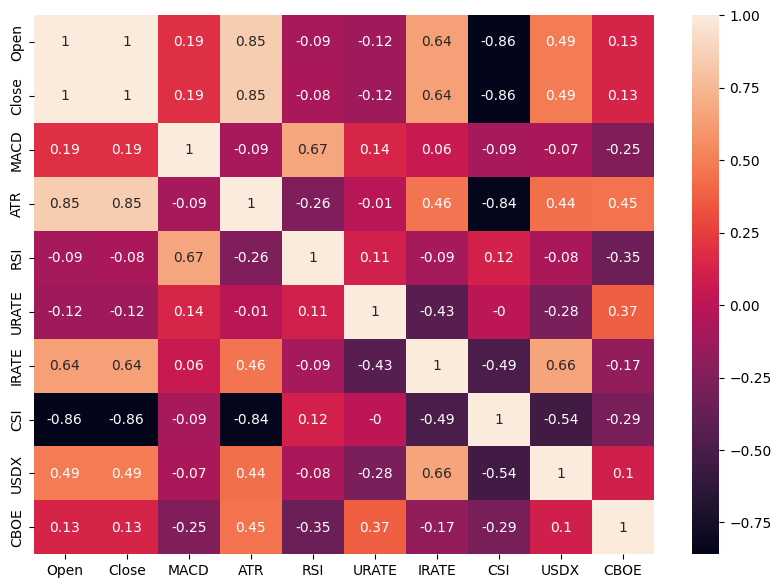

In [141]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 7))
df_corr = df.corr().round(2)
sns.heatmap(df_corr, annot=True)

In [142]:
df = df.drop("Open", axis=1) # High Correlation

In [143]:
df

,Close,MACD,ATR,RSI,URATE,IRATE,CSI,USDX,CBOE
Datetime,,,,,,,,,
2016-03-22,24.169992,0.769228,0.423358,84.330971,5.1,0.37,89.0,95.650002,14.170000
2016-03-23,24.036367,0.750690,0.412046,80.325022,5.1,0.37,89.0,96.050003,14.940000
2016-03-24,23.932192,0.719301,0.404615,77.244334,5.1,0.37,89.0,96.139999,14.740000
2016-03-28,23.823483,0.677839,0.393994,74.052627,5.1,0.37,89.0,95.940002,15.240000
2016-03-29,24.387421,0.682616,0.412927,78.918923,5.1,0.37,89.0,95.160004,13.820000
...,...,...,...,...,...,...,...,...,...
2026-02-09,274.619995,2.680348,6.026760,63.218734,4.4,3.72,52.9,96.820000,17.360001
2026-02-10,273.679993,2.945728,5.769848,61.599554,4.4,3.72,52.9,96.800003,17.790001
2026-02-11,275.500000,3.265263,5.822001,63.546345,4.4,3.72,52.9,96.830002,17.650000
